In [70]:
import yfinance as yf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sb
from scipy.stats import skew
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates

##### Fetch Live stock data 

In [50]:
stock = yf.Ticker("CESC.NS")
data = stock.history(period="3y", interval="1d")

data.index = data.index.date  # converts to plain date (datetime.date object)
# Select only numerical columns and round to 2 decimal places
data = data.round(2)
# ṛemoving not needed columns from the data
data = data[["Close", "Open" , "Low" , "High" , "Volume"]]

In [51]:
print("Stock Price of last 5 days :::")
data.tail()

Stock Price of last 5 days :::


,Close,Open,Low,High,Volume
2025-08-04,163.80,166.13,162.51,166.86,2479637
2025-08-05,164.27,164.20,162.50,167.07,2211894
2025-08-06,161.52,164.27,161.23,165.44,2795400
2025-08-07,165.84,161.40,160.50,170.27,18187448
2025-08-08,163.19,166.15,162.01,166.24,2642507


##### Neccesary Data pre-processing steps 

In [52]:
# check for missing values
print("Missing values in data >>>\n")
data.isna().sum()

Missing values in data >>>



Close     0
Open      0
Low       0
High      0
Volume    0
dtype: int64

In [53]:
# Summary statistics of numerical columns
print("summary statistics  \n",data.describe())

summary statistics  
             Close        Open         Low        High        Volume
count  742.000000  742.000000  742.000000  742.000000  7.420000e+02
mean   118.351011  118.487493  116.464380  120.512749  5.352938e+06
std     45.340443   45.419241   44.380197   46.372999  6.363200e+06
min     59.420000   59.660000   58.390000   61.260000  0.000000e+00
25%     69.850000   69.792500   69.012500   70.690000  2.021745e+06
50%    124.940000  125.305000  122.200000  127.540000  3.626648e+06
75%    163.052500  163.385000  160.845000  166.065000  6.162648e+06
max    202.320000  202.800000  196.700000  206.280000  7.028120e+07


##### Stock Price Visualization 

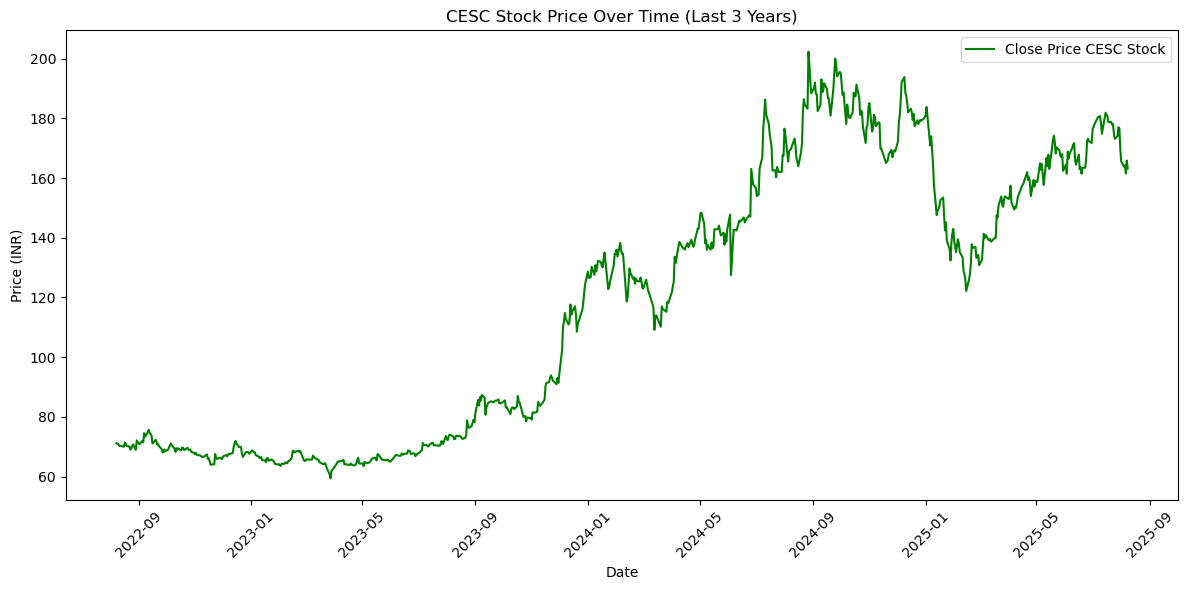

In [54]:
# stock price over the time using line chart
plt.figure(figsize=(12, 6))
sb.lineplot(data=data, x=data.index, y="Close", label="Close Price CESC Stock" , color="green")
plt.title("CESC Stock Price Over Time (Last 3 Years)")
plt.xlabel("Date")
plt.ylabel("Price (INR)")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

##### Scatter plot shows the association between two variable (how much they're depended)

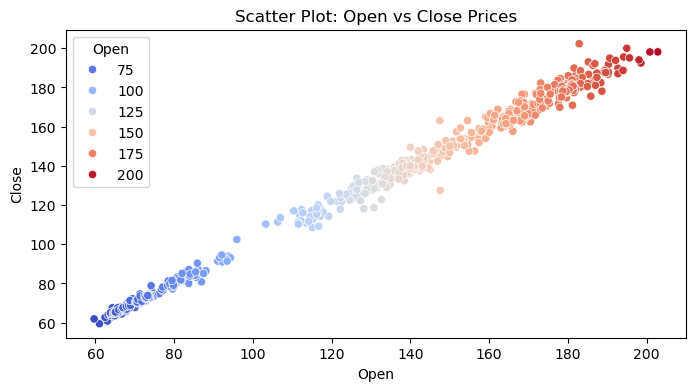

In [55]:
# Scatter plot between Open & Close prices
plt.figure(figsize=(8, 4))
sb.scatterplot(x=data['Open'], y=data['Close'], hue=data['Open'], palette='coolwarm')
plt.title("Scatter Plot: Open vs Close Prices")
plt.show()

##### Heatmap shows the correlations of all the numerical cols and shows how all are connected

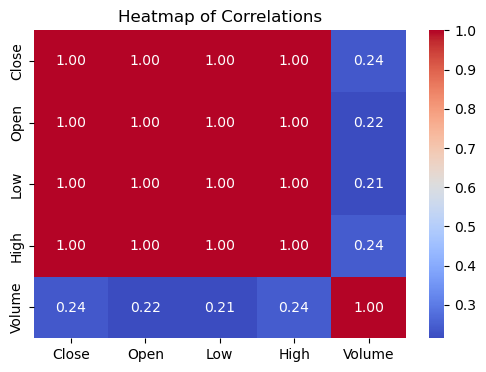

In [56]:
numeric_cols = data.select_dtypes(include=['float64', 'int64'])
# heatmap for visualizing relationships between numerical columns
plt.figure(figsize=(6, 4))
sb.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Heatmap of Correlations")
plt.show()

###### Rule of thumb:-
- 0.5 < skew < 0.5 → fairly symmetrical
- Otherwise → consider transformation

In [57]:
print("Skewness (Close):", skew(data['Close']))
print("Skewness (Open):", skew(data['Open']))
print("Skewness (High):", skew(data['High']))
print("Skewness (Low):", skew(data['Low']))
print("Skewness (Volume):", skew(data['Volume']))

Skewness (Close): 0.12385275737756613
Skewness (Open): 0.12651616800850857
Skewness (High): 0.11839712331089683
Skewness (Low): 0.1369273299271371
Skewness (Volume): 4.6471660846202925


#### Skewness Analysis 
- Close = 0.124 -> 	Almost symmetrical — no serious skew.
- Open = 0.127 -> 	Almost symmetrical — no serious skew.
- High = 0.118 -> 	Almost symmetrical — no serious skew.
- Low = 0.137 -> 	Almost symmetrical — no serious skew.
- Volume = 4.647 -> Highly positively skewed — heavy right tail (some days have extremely high volume compared to others).

In [65]:
# Volume:
# Extremely skewed — a few trading days have unusually high volumes.
# This can cause LSTM to overemphasize rare spikes.
# Solution : Log transformation to reduce skewness.

## As of now, we are not using volume in our model, but if we do, we can apply log transformation to reduce skewness in future. 

##### Including Other Features/Variables such as %change, EMA and so on

##### Daily % Change in close price

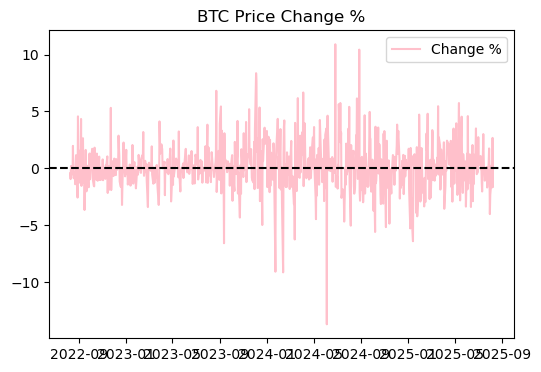

In [66]:
# price changes in %
data["change%"] =  data["Close"].pct_change() *100
# graph depicting the % change
plt.figure(figsize=(6,4))
plt.plot(data["change%"] , label="Change %" , color="pink")
plt.title("BTC Price Change %")
plt.axhline(y=0 , color="black" , linestyle="--")
plt.legend()
plt.show()

##### MA - Moving Averages

         2025-08-04  2025-08-05  2025-08-06  2025-08-07  2025-08-08
Close    163.800000  164.270000  161.520000  165.840000  163.190000
Open     166.130000  164.200000  164.270000  161.400000  166.150000
Low      162.510000  162.500000  161.230000  160.500000  162.010000
High     166.860000  167.070000  165.440000  170.270000  166.240000
Volume     0.842916    0.842079    0.843786    0.856291    0.843379
change%   -1.045128    0.286935   -1.674073    2.674591   -1.597926
MA7      171.368571  170.105714  168.324286  166.725714  164.808571
MA30     175.787333  175.711000  175.348333  175.103333  174.799667


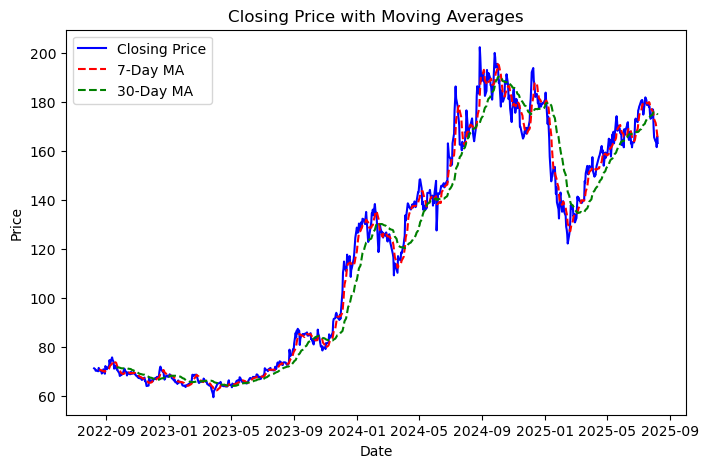

In [68]:
# calculate the moving average  > avg moving price over the time period
data["MA7"] = data["Close"].rolling(window=7).mean()
data["MA30"] = data["Close"].rolling(window=30).mean()

print(data.tail().T)

# Plot Closing Price with Moving Averages
plt.figure(figsize=(8, 5))
plt.plot( data["Close"], label="Closing Price", color='blue')
plt.plot(data["MA7"], label="7-Day MA", color='red', linestyle="dashed")
plt.plot( data["MA30"], label="30-Day MA", color='green', linestyle="dashed")
plt.title("Closing Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.show()


##### RSI - Relative Strength Index, ATR- Average True range and others

In [69]:
def compute_RSI(data, window=14):
    delta = data["Close"].diff() # Calculate daily price change (Close price today - yesterday).
    # If the change is positive ➔ Keep it, otherwise ➔ Set to 0. Then, take a moving average of gains over the past 14 days.
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean() 
    # If the change is negative ➔ Take the positive value of it (i.e., losses). Then, moving average of losses over 14 days.
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    RS = gain / loss
    return 100 - (100 / (1 + RS))

data["RSI_14"] = compute_RSI(data)

# Volatility: Standard Deviation of Close Price over 7-day window
data['Volatility_7'] = data['Close'].rolling(window=7).std()

# Average True Range (ATR) - Measures market volatility
data['ATR_14'] = (data['High'] - data['Low']).rolling(window=14).mean()

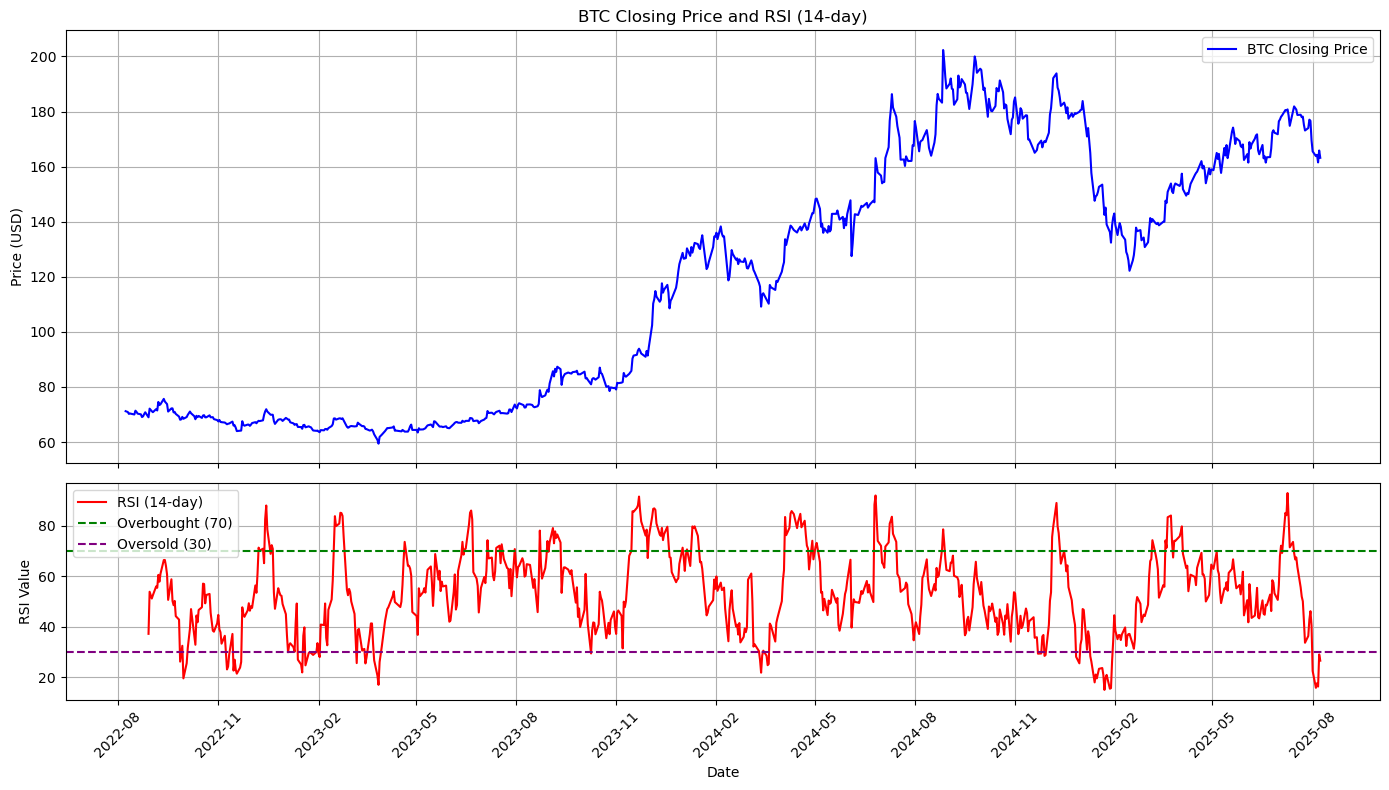

In [71]:
# Plot closing price and RSI in two subplots
fig, ax = plt.subplots(2, 1, figsize=(14, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

# Plot closing price in the first subplot
ax[0].plot(data.index, data['Close'], color='blue', label='BTC Closing Price')
ax[0].set_title('BTC Closing Price and RSI (14-day)')
ax[0].set_ylabel('Price (USD)')
ax[0].legend()
ax[0].grid()

# Plot RSI in the second subplot
ax[1].plot(data.index, data['RSI_14'], color='red', label='RSI (14-day)')
ax[1].axhline(70, color='green', linestyle='--', label='Overbought (70)')
ax[1].axhline(30, color='purple', linestyle='--', label='Oversold (30)')
ax[1].set_ylabel('RSI Value')
ax[1].set_xlabel('Date')
ax[1].legend()
ax[1].grid()

# Format x-axis dates for better readability
ax[1].xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax[1].xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### Other visualization 

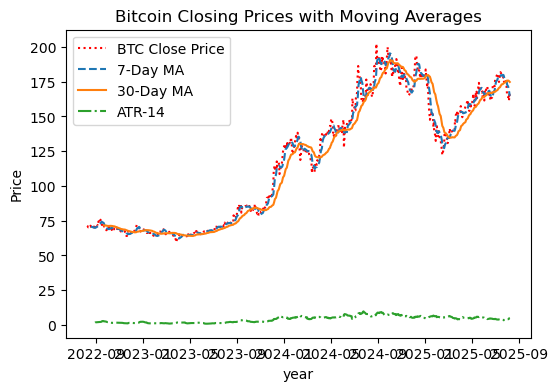

In [72]:
# visualize indicators
plt.figure(figsize=(6, 4))
plt.plot( data['Close'], label="BTC Close Price", color='red' , linestyle=":")
plt.plot(data['MA7'], label='7-Day MA', linestyle="--")
plt.plot(data['MA30'], label='30-Day MA', linestyle='-')
plt.plot(data["ATR_14"] , label="ATR-14" , linestyle="-.")
plt.title("Bitcoin Closing Prices with Moving Averages")
plt.xlabel("year")
plt.ylabel("Price")
plt.legend()
plt.show()

##### BB - Bollinger Bands

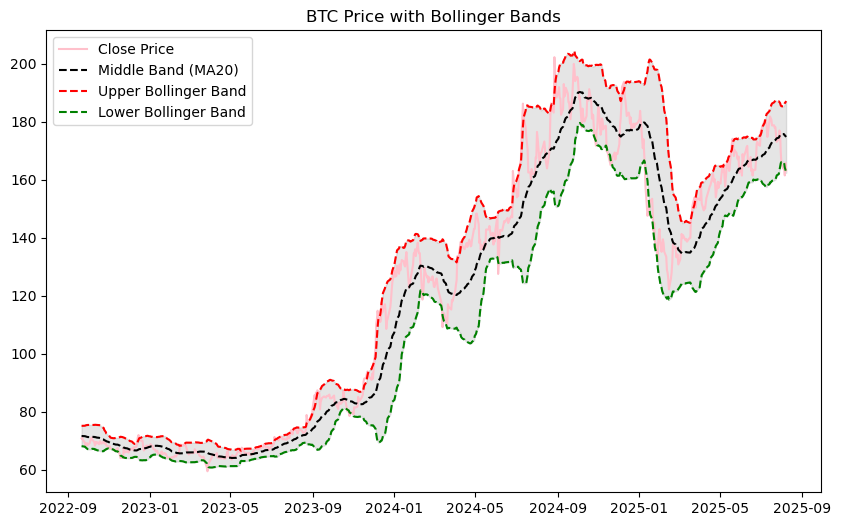

In [73]:
#middle band
data["MidBand"] = data["MA30"]
# calculate the std deviation for rolling window
data["Std_Deviation"] = data["Close"].rolling(window=30).std()
#lower and upper band
data["LowerBand"] = data["MidBand"] -( 2 * data["Std_Deviation"])
data["UpperBand"] = data["MidBand"] + ( 2 * data["Std_Deviation"])

# Drop NaN values (caused by rolling calculations)
data.dropna(inplace=True)

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['Close'], label="Close Price", color='pink')
plt.plot(data.index, data['MidBand'], label="Middle Band (MA20)", color='black', linestyle='dashed')
plt.plot(data.index, data['UpperBand'], label="Upper Bollinger Band", color='red', linestyle='dashed')
plt.plot(data.index, data['LowerBand'], label="Lower Bollinger Band", color='green', linestyle='dashed')

plt.fill_between(data.index, data['LowerBand'], data['UpperBand'], color='gray', alpha=0.2)  # Shaded Bollinger area
plt.title("BTC Price with Bollinger Bands")
plt.legend()
plt.show()


In [74]:
## Adding a trend column to the data
# This column indicates whether the price is expected to go up (1) or down (0
data['Trend'] = (data['Close'].shift(-1) > data['Close']).astype(int)

In [76]:
print("Overview of dataset after adding some features \n\n")
data = data.round(2)  # rounding off the values for better readability
data.tail()

Overview of dataset after adding some features 




,Close,Open,Low,High,Volume,change%,MA7,MA30,RSI_14,Volatility_7,ATR_14,MidBand,Std_Deviation,LowerBand,UpperBand,Trend
2025-08-04,163.80,166.13,162.51,166.86,0.84,-1.05,171.37,175.79,15.90,5.23,4.12,175.79,4.78,166.23,185.35,1
2025-08-05,164.27,164.20,162.50,167.07,0.84,0.29,170.11,175.71,17.73,5.78,4.31,175.71,4.95,165.82,185.61,0
2025-08-06,161.52,164.27,161.23,165.44,0.84,-1.67,168.32,175.35,16.40,6.28,4.45,175.35,5.56,164.23,186.47,1
2025-08-07,165.84,161.40,160.50,170.27,0.86,2.67,166.73,175.10,29.13,4.99,4.94,175.10,5.81,163.48,186.73,0
2025-08-08,163.19,166.15,162.01,166.24,0.84,-1.60,164.81,174.80,26.65,2.53,5.04,174.80,6.19,162.42,187.18,0
